### Network Reduction 
This page demonstrates network reduction techniques that could be used to reduce graph size for network analysis and to identify relationships of interest. 

The data used for the analysis is a dataset that represent online forum posting of UC Irvine students. The dataset is obtained from http://konect.uni-koblenz.de/networks/. The dataset provides edgelist which is bipartite and multi-edge list. In order to do the analysis the multiple edges between same pair of nodes will be converted to single edge with weight of the edge equal to the number of edges. 


**Import required pacakge** 

In [1]:
import networkx as nx
import matplotlib
import urllib
import pandas as pd
#Make plots inline
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,10)

#### Process Input file
Load data from web using urllib pacakge. Then parse the file to obtain edge list.

In [2]:
#Read file from gitbub.
forum_file = urllib.urlopen("https://raw.githubusercontent.com/mkds/MSDA/master/DATA620/DATA/out.opsahl-ucforum")
forum_edges=pd.read_csv(forum_file,delim_whitespace=True,names=('User','Forum','Weight'),
                                   skiprows=2,usecols=(0,1,2))




The dataset is bipariate but the node number between the two sets are overlapping. In the edge list the first node is User. Let's differentiate forum node by prefixing fr to node id of forums.

In [3]:
forum_edges['ForumID'] = 'fr'+forum_edges['Forum'].astype('str')
forum_edges.drop('Forum',axis=1,inplace=True)

Now, let's consolidate edge list by coverting multiple edges between same pair of nodes to single edge with weight of the edge equal to the number of edges. 

In [4]:
edges_grouped=forum_edges.groupby(['User','ForumID'])
weighted_edges=edges_grouped.sum().reset_index().values
print "Sample Processed Edge:",weighted_edges[0]

Sample Processed Edge: [1 'fr1' 11]


#### Create graph
Let's create the Bipartite graph using the processed data.

In [5]:
forum_graph = nx.Graph()
forum_graph.add_nodes_from(set(forum_edges["User"]),bipartite=0)
forum_graph.add_nodes_from(set(forum_edges["ForumID"]),bipartite=1)
forum_graph.add_weighted_edges_from(weighted_edges)
all_forums=[fr for fr, b in forum_graph.nodes(data=True) if b['bipartite'] == 1]
all_users=[u for u, b in forum_graph.nodes(data=True) if b['bipartite'] == 0]
print "Number of Users", len(all_users)
print "Number of Forums", len(all_forums)
print "Number of postings",len(forum_graph.edges())

Number of Users 899
Number of Forums 522
Number of postings 7089


#### Graph Diagram
Let's draw the graph. The users are coded as green and the forums are color coded as purple in the below graph

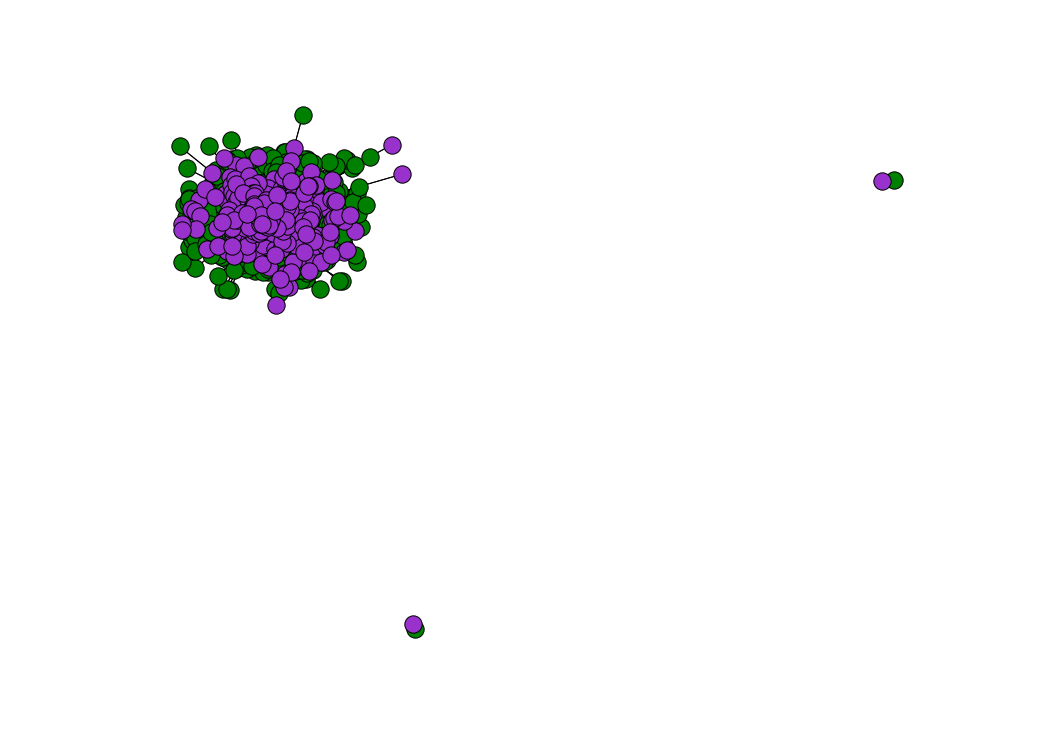

In [6]:
pos=nx.spring_layout(forum_graph)
nx.draw(forum_graph,pos=pos,node_color='g',nodelist=set(forum_edges['User']))
nx.draw(forum_graph,pos=pos,node_color='darkorchid',nodelist=set(forum_edges['ForumID']))          

#### Graph Reduction - Island Method 
Let's define a function to reduce the graph based on the edge weight. The below function returns a graph which containts only edges with weight greater than the desired weight and nodes which has such edges.

In [7]:
def prune_edges(g, weight=1):
    pruned_graph = g.copy()
    for f, to, edata in pruned_graph.edges(data=True):
            if edata['weight'] < weight:
                    pruned_graph.remove_edge(f,to)
    zero_degree_nodes=[n for n,d in nx.degree(pruned_graph).items() if d==0]
    pruned_graph.remove_nodes_from(zero_degree_nodes)
    return pruned_graph


Let's use the island method to reduce the graph such that it has only edges with weight greater than 10

In [8]:
forum_graph_small=prune_edges(forum_graph,10)
pos1=nx.spring_layout(forum_graph_small)
users=[n for n, b in forum_graph_small.nodes(data=True) if b['bipartite'] == 0]
forums=[n for n, b in forum_graph_small.nodes(data=True) if b['bipartite'] == 1]
print "Number of forums in reduced graph:",len(forums)
print "Number of Users in reduced Graph:",len(users)

Number of forums in reduced graph: 235
Number of Users in reduced Graph: 237


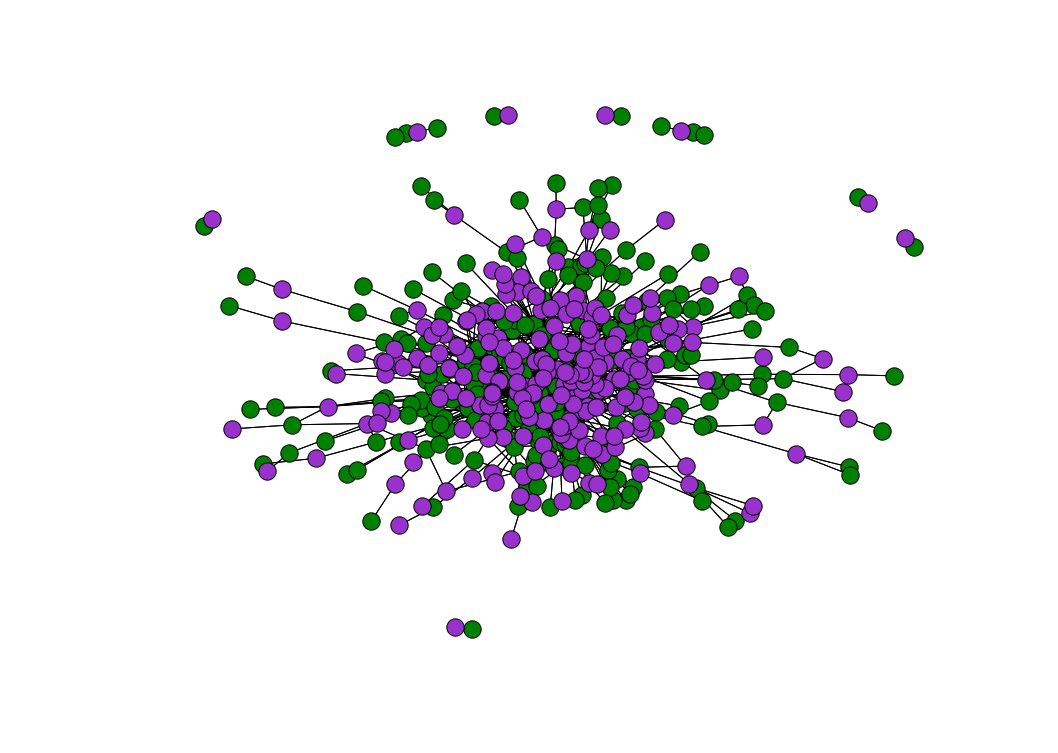

In [9]:
nx.draw(forum_graph_small,pos=pos1,node_color='g',nodelist=users)
nx.draw(forum_graph_small,pos=pos1,node_color='darkorchid',nodelist=forums)

As the above graph still looks crowded let's try Let's reduce the graph such that it has only edges with weight greater than 50

Number of forums in reduced graph: 16
Number of Users in reduced Graph: 22


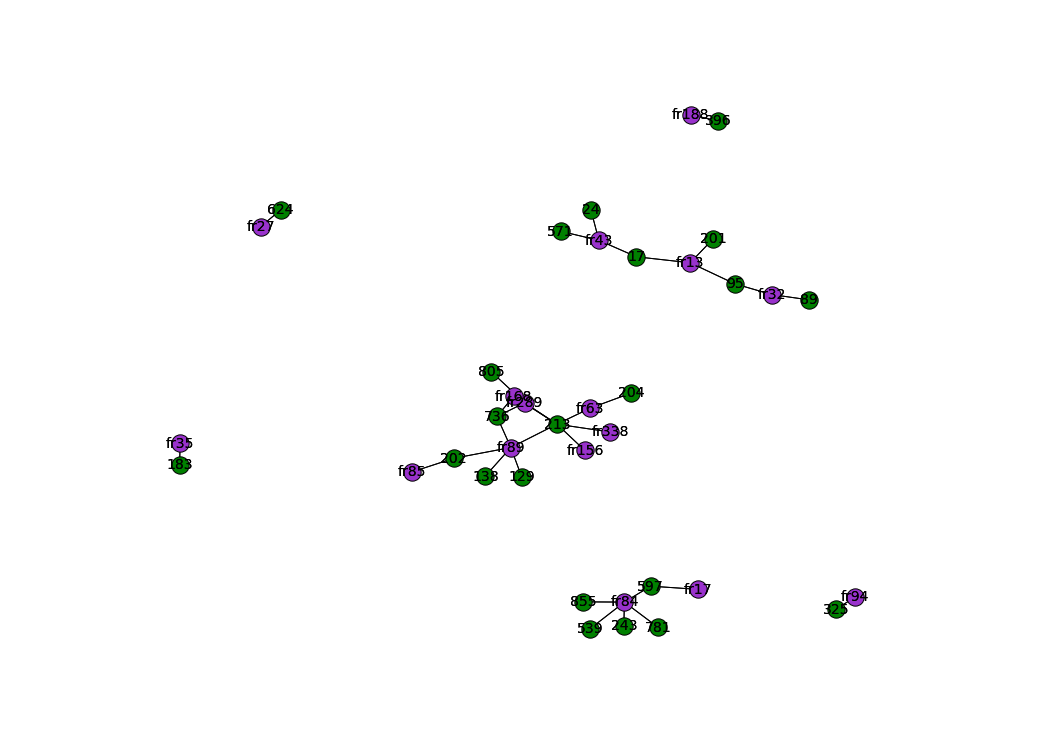

In [10]:
forum_graph_small=prune_edges(forum_graph,50)
pos1=nx.spring_layout(forum_graph_small)
users=[n for n, b in forum_graph_small.nodes(data=True) if b['bipartite'] == 0]
forums=[n for n, b in forum_graph_small.nodes(data=True) if b['bipartite'] == 1]
print "Number of forums in reduced graph:",len(forums)
print "Number of Users in reduced Graph:",len(users)
nx.draw(forum_graph_small,pos=pos1,node_color='g',nodelist=users,with_labels=True,font_size=14)
nx.draw(forum_graph_small,pos=pos1,node_color='darkorchid',nodelist=forums,with_labels=True,font_size=14)

Now we could see a bunch of users who have made more than 50 posts to one or more forums. This disconnected graphs provides smaller sub-groups which may have common interests. The topics within each group could be considered similiar in nature and the people in this group would have at least one common interest. 

#### Cliques 
Another graph reduction technqiue that could be used to find well connected subgraph is Clique. In order to get insight of relationship between users let's project the bipartite graph to get relationship betewen users.

In [11]:
user_projection=nx.algorithms.bipartite.weighted_projected_graph(forum_graph,all_users)
print "User Projection",user_projection.edges(data=True)[1:5]

User Projection [(1, 4, {'weight': 3}), (1, 5, {'weight': 4}), (1, 6, {'weight': 1}), (1, 7, {'weight': 3})]


Now, let's add this user relation to the forum graph, so that we will have a graph which represent user posting as well as links between users who posted to same forum

In [12]:
user_weighted_edges=[(f,t,a['weight']) for f,t,a in user_projection.edges(data=True) ]
forum_graph.add_weighted_edges_from(user_weighted_edges)

Now, let's use the island method to get a subgraph of users who did more than 20 posting to one or more forums

In [13]:
forum_graph_small=prune_edges(forum_graph,10)
pos1=nx.shell_layout(forum_graph_small)
users=[n for n, b in forum_graph_small.nodes(data=True) if b['bipartite'] == 0]
forums=[n for n, b in forum_graph_small.nodes(data=True) if b['bipartite'] == 1]
print "Number of forums in reduced graph:",len(forums)
print "Number of Users in reduced Graph:",len(users)

Number of forums in reduced graph: 235
Number of Users in reduced Graph: 250


Now let's look for Clique groups that have atleast 5 users/topics.

In [14]:
clique_groups=list(nx.find_cliques(forum_graph_small))
large_clique_groups = [gr for gr in clique_groups if len(gr) > 4]
for gr in large_clique_groups:
    print "Clique Group:",gr
large_cl_nodes=[n for gr in large_clique_groups for n in gr]

Clique Group: [213, 435, 736, 'fr104', 443]
Clique Group: [213, 65, 67, 736, 24]
Clique Group: [213, 65, 67, 736, 361]
Clique Group: [213, 65, 67, 736, 'fr168']
Clique Group: [213, 65, 67, 736, 'fr287']
Clique Group: [213, 65, 67, 736, 271, 489]
Clique Group: [213, 65, 67, 34, 'fr287']
Clique Group: [213, 65, 67, 34, 489, 539]
Clique Group: [213, 65, 67, 34, 489, 271]
Clique Group: [213, 65, 67, 34, 'fr168']
Clique Group: [213, 65, 67, 147, 361]
Clique Group: [213, 65, 67, 219, 489]
Clique Group: [213, 65, 518, 736, 489]
Clique Group: [213, 65, 50, 489, 271]
Clique Group: [213, 65, 'fr419', 736, 24]
Clique Group: [213, 422, 736, 67, 24]
Clique Group: [213, 422, 736, 67, 489, 271]
Clique Group: [213, 277, 34, 67, 271]


**From clique group list we could see that user 213,65 and 67 often make multiple posts together on multiple forums. This indictates that user 213, 65 and 67 could have one or more common interest**

Let's reduce the graph to have only large clique groups listed above and visualize the graph

In [15]:
#Reduce the graph to have only clique groups
for n in forum_graph_small.nodes():
    if (n not in large_cl_nodes):
        forum_graph_small.remove_node(n)
        
for f,t in forum_graph_small.edges():
    in_clique = False
    for gr in large_clique_groups:
        if (f in gr) or (t in gr):
            in_clique = True
            break
    if (not in_clique):
        forum_graph_small.remove_edge((f,t))

Number of forums in reduced graph: 4
Number of Users in reduced Graph: 18


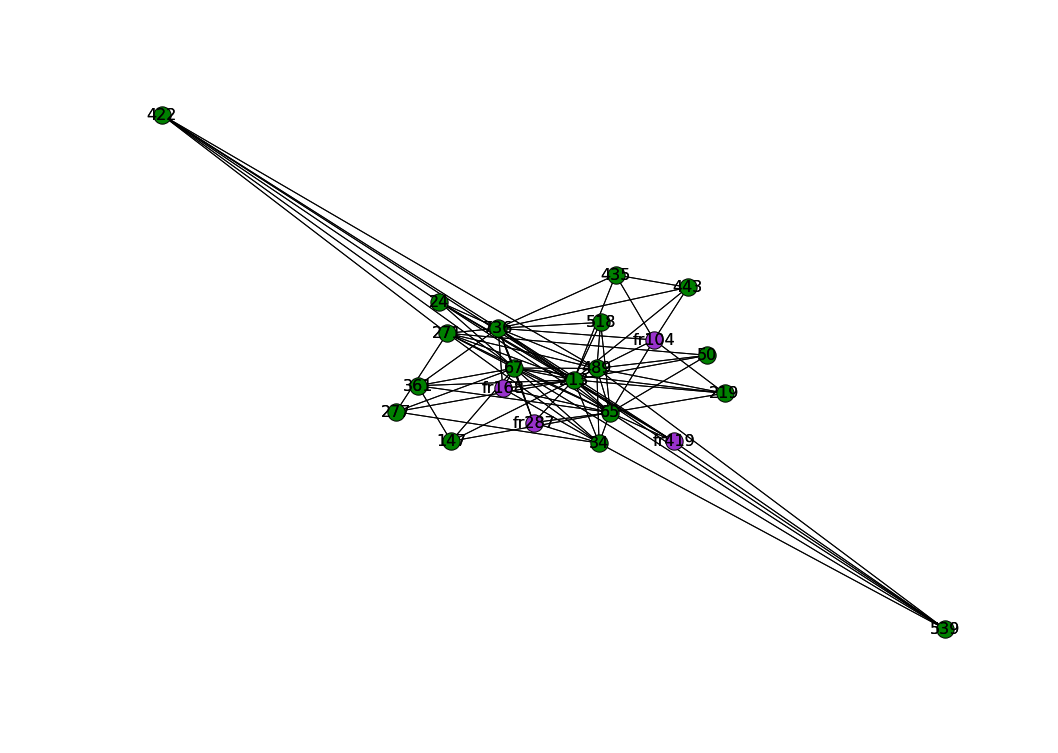

In [16]:
pos1=nx.spring_layout(forum_graph_small)
users=[n for n, b in forum_graph_small.nodes(data=True) if b['bipartite'] == 0]
forums=[n for n, b in forum_graph_small.nodes(data=True) if b['bipartite'] == 1]
print "Number of forums in reduced graph:",len(forums)
print "Number of Users in reduced Graph:",len(users)
nx.draw(forum_graph_small,pos=pos1,node_color='g',nodelist=users,with_labels=True,font_size=16)
nx.draw(forum_graph_small,pos=pos1,node_color='darkorchid',nodelist=forums,with_labels=True,font_size=16)

By using graph reduction technique we could identify features of interest. The island reduction technique could be used to see nodes with high degree or with high total edge weight. The clique technique could be used to find a well connected sub-group. Using island technique we could identify forums that have high-frequent users (i.e. users making more than n number of posts) and topics which could be similar in nature. Using clique we are able to identify group of people who made multiple posts together on one or more forums.  